# Data Preparation Tutorial - Liver Vizgen

This Jupyter notebook serves as a continuous demonstration of the step-by-step process involved in preparing input files for Spatial-live visualization. In a manner akin to the preceding tutorial centered on kidney data sourced from the 10X Visium platform, this tutorial shifts its focus to liver MERFISH data obtained from the Vizgen platform. This specific dataset measures 347 genes across a substantial >300,000 liver cells in a single mouse liver slice. For the purpose of this demonstration, we have customized and tailored the notebook, drawing inspiration from the [squidpy mouse liver tutorial](https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_vizgen_mouse_liver.html) to align with our objectives.


## Python virtual environment setup

In order to run this Jupyter Notebook and streamline the process for your convenience, we have compiled several supplementary files including "requirements.txt", which you can use to easily set up a Python virtual environment. 

In [1]:
# Please git clone the spatial-live from github, 
# and change the WORKROOTDIR to your own working directory
%env WORKROOTDIR=/Users/zhenqingye/projects/spatial-live

env: WORKROOTDIR=/Users/zhenqingye/projects/spatial-live


In [2]:
# You can use the below requirements.txt to create your virtual environment
! tree -L 1 ${WORKROOTDIR}/quickdemo/

/Users/zhenqingye/projects/spatial-live/quickdemo/
├── kidney
├── liver
└── requirements.txt

2 directories, 1 file


## Vizgen MERFISH Mouse Liver data preparation

You probably noticed the "liver" folder in the above layout, which contains several files of the Liver1Slice1 dataset from Vizgen’s MERFISH Mouse Liver Map: https://info.vizgen.com/mouse-liver-access. In order to run this tutorial we will download the cell_by_gene.csv and cell_metadata.csv, as well as the image-related files including manifest.json, micron_to_mosaic_pixel_transform.csv, mosaic_DAPI_z0.tif, and mosaic_PolyT_z0.tif. We didn't include these data files in our git repo. Please follow the instructions to obtain access to the showcase data and download the data.

In [3]:
! tree ${WORKROOTDIR}/quickdemo/liver/

/Users/zhenqingye/projects/spatial-live/quickdemo/liver/
└── liver1slice1
    ├── cell_by_gene.csv
    ├── cell_metadata.csv
    └── images
        ├── manifest.json
        ├── micron_to_mosaic_pixel_transform.csv
        ├── mosaic_DAPI_z0.tif
        └── mosaic_PolyT_z0.tif

2 directories, 6 files


In [4]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scanpy as sc 
import squidpy as sq
import pandas as pd

import rasterio
from rasterio.enums import Resampling
from skimage import transform
import cv2
from PIL import Image

from copy import deepcopy

pd.options.display.precision=3

sc.logging.print_header()

scanpy==1.9.5 anndata==0.9.2 umap==0.5.4 numpy==1.23.4 scipy==1.11.2 pandas==2.1.0 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10


In [5]:
# please change the rootdir to your own working directory accordingly
rootdir = "/Users/zhenqingye/projects/spatial-live/"
library_id = "liver1slice1"
datadir = rootdir + 'quickdemo/liver/'

## Base Image Preprocessing
From Vizgen, a selection of TIF images pertinent to this liver sample has been made available. Specifically, for the purpose of this demonstration, we have chosen to work with the DAPI_z0 and PolyT_z0 images. Given their considerable dimensions, we've taken the initiative to downsample and rescale them to more compact sizes using a designated scale factor.

In [6]:
scale_factor = 1/16

dapi_tif  = rasterio.open(datadir + library_id + "/images/mosaic_DAPI_z0.tif")
polyt_tif = rasterio.open(datadir + library_id + "/images/mosaic_PolyT_z0.tif")

In [7]:
# resample data to target shape
dapi_blue = dapi_tif.read(
        out_shape=(
            int(dapi_tif.height * scale_factor),
            int(dapi_tif.width * scale_factor)
        ),
        resampling=Resampling.bilinear
)

polyt_green = polyt_tif.read(
        out_shape=(
            int(polyt_tif.height * scale_factor),
            int(polyt_tif.width * scale_factor)
        ),
        resampling=Resampling.bilinear
)

In [8]:
dapi_blue = np.squeeze(dapi_blue)
polyt_green = np.squeeze(polyt_green)

In [9]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    range_norm = (band-band_min)/(band_max - band_min)
    return np.array(range_norm * 255, dtype=np.uint8)
    
dapi_blue = normalize(dapi_blue) 
polyt_green = normalize(polyt_green)
zero_red = np.zeros(dapi_blue.shape, dtype=np.uint8)

In [10]:
im = cv2.merge((zero_red, polyt_green, dapi_blue*2))

(-0.5, 5988.5, -0.5, 5630.5)

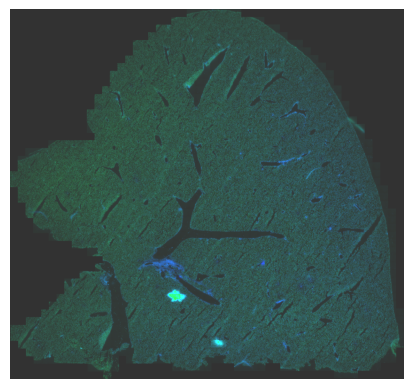

In [11]:
# define the alpha and beta
alpha = 1.5 # Contrast control
beta = 50 # Brightness control

# call convertScaleAbs function
adjusted = cv2.convertScaleAbs(im, alpha=alpha, beta=beta)
plt.imshow(adjusted, origin='lower')
plt.axis("off")

In [12]:
! mkdir -p ${WORKROOTDIR}/quickdemo/liver/output

In [13]:
img = Image.fromarray(adjusted)
img.save(datadir + 'output/liver_demo.png')

In [14]:
! tree ${WORKROOTDIR}/quickdemo/liver/output/

/Users/zhenqingye/projects/spatial-live/quickdemo/liver/output/
└── liver_demo.png

0 directories, 1 file


## Data preprocessing and quality control
Likewise, we will navigate through the conventional single-cell analysis pipeline.

First, we load the cell-by-gene and cell-metadata CSVs and construct an AnnData object.

In [15]:
adata = sq.read.vizgen(datadir + library_id, 
    counts_file="cell_by_gene.csv",
    meta_file="cell_metadata.csv",
    transformation_file="micron_to_mosaic_pixel_transform.csv",
    library_id = library_id )

In [16]:
adata

AnnData object with n_obs × n_vars = 395215 × 347
    obs: 'fov', 'volume', 'min_x', 'max_x', 'min_y', 'max_y'
    uns: 'spatial'
    obsm: 'blank_genes', 'spatial'

In [17]:
adata.uns['spatial']

{'liver1slice1': {'metadata': {},
  'scalefactors': {'transformation_matrix':        0      1        2
   0  9.259  0.000  385.306
   1  0.000  9.259  999.818
   2  0.000  0.000    1.000}}}

Configuring pertinent parameters for the spatial imaging entity.

In [18]:
adata.uns['spatial'][library_id]['images'] = {}
adata.uns['spatial'][library_id]["images"] = {"hires": adjusted}
adata.uns['spatial'][library_id]['scalefactors'].update({'tissue_hires_scalef': 1.0})
adata.uns['spatial'][library_id]['scalefactors'].update({'spot_diameter_fullres': 5})

Rescaling and converting micron coordinates to pixel positions based on the adjsted image.

In [19]:
transmtx = adata.uns['spatial'][library_id]['scalefactors']['transformation_matrix'].values
pixel_positions = [ scale_factor * transform.matrix_transform(micron, transmtx) for micron in adata.obsm['spatial'] ]
adata.obsm['spatial'] = np.squeeze(np.array(pixel_positions))

In [20]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=(50, 100, 200, 300), inplace=True
)

In [21]:
sc.pp.filter_cells(adata, min_counts=50)
sc.pp.filter_genes(adata, min_cells=10)

In [22]:
print("normalize total")
sc.pp.normalize_total(adata)
print("log transform")
sc.pp.log1p(adata)
print("scale")
sc.pp.scale(adata, max_value=10)

normalize total
log transform
scale


Dimensionality Reduction, Neighbor Calculation, and Clustering

In [23]:
print("PCA")
sc.tl.pca(adata, svd_solver="arpack")
print("neighbors")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
print("UMAP")
sc.tl.umap(adata)

PCA
neighbors
UMAP


In [24]:
resolution = 1.5
print("Leiden")
sc.tl.leiden(adata, resolution=resolution)

Leiden


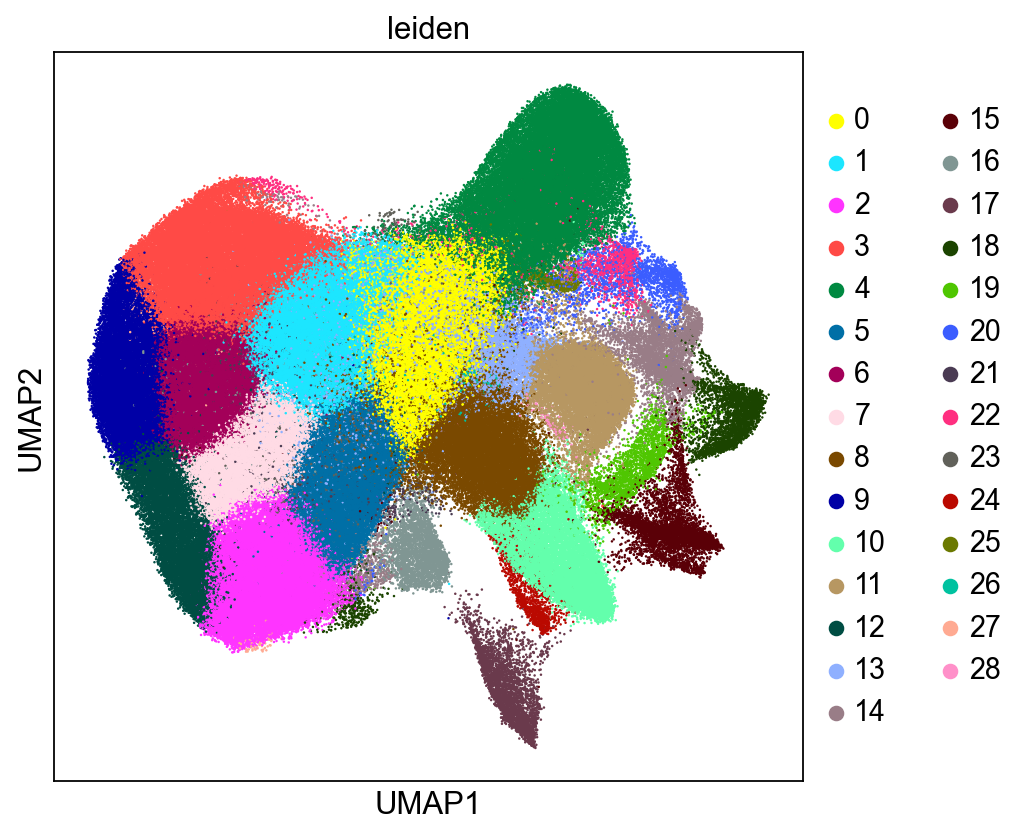

In [25]:
sc.set_figure_params(figsize=(6, 6))
sc.pl.umap(adata, color=["leiden"], size=5)

## Spatial Distributions of Cells

Here we visualize the spatial locations of cells in the mouse liver colored by Leiden cluster. 

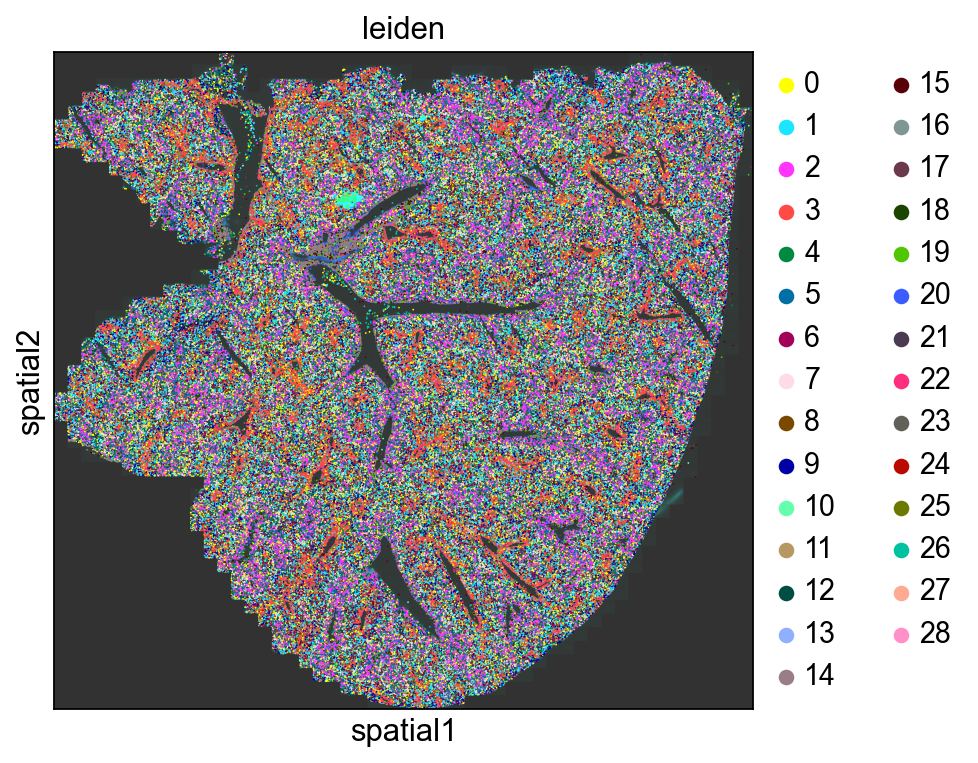

In [26]:
sq.pl.spatial_scatter( adata, img="hires", color="leiden", library_id=library_id, figsize=(6, 6), size=3 )

## Assign Cell Types

### Reference Cell Type Marker Gene Sets

We adhere to the guidelines outlined in the [squidpy tutorial](https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_vizgen_mouse_liver.html) to allocate liver cell types, and utilize a gene-level cell type marker reference from the publication titled ["Spatial transcriptome profiling by MERFISH reveals fetal liver hematopoietic stem cell niche architecture."](https://www.nature.com/articles/s41421-021-00266-1) These marker genes serve as pivotal elements in evaluating the cell type composition of the Leiden clusters.

In [27]:
gene_panel = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41421-021-00266-1/MediaObjects/41421_2021_266_MOESM1_ESM.xlsx"
df_ref_panel_ini = pd.read_excel(gene_panel, index_col=0)
df_ref_panel = df_ref_panel_ini.iloc[1:, :1]
df_ref_panel.index.name = None
df_ref_panel.columns = ["Function"]

# Assign marker gene metadata using reference dataset
marker_genes = df_ref_panel[
    df_ref_panel["Function"].str.contains("marker")
].index.tolist()

meta_gene = deepcopy(adata.var)
common_marker_genes = list(set(meta_gene.index.tolist()).intersection(marker_genes))
meta_gene.loc[common_marker_genes, "Markers"] = df_ref_panel.loc[
    common_marker_genes, "Function"
]
meta_gene["Markers"] = meta_gene["Markers"].apply(
    lambda x: "N.A." if "marker" not in str(x) else x
)
meta_gene["Markers"].value_counts()

Markers
N.A.                            285
HSC marker                        8
Hepatocyte marker                 5
Erythroid progenitor marker       5
Macrophage marker                 5
SEC marker                        5
Neutrophil marker                 5
MK marker                         5
Potential HSC marker              5
Pre-B cell marker                 5
Erythroid cell marker             4
EC marker                         4
AEC marker                        2
Myeloid marker                    2
Macrophage/Hepatocyte marker      1
Basophil marker                   1
Name: count, dtype: int64

### Calculate Leiden Cluster Average Expression Signatures
Here we calculate the average gene expression signatures of the Leiden clusters, which will be used to assign cell type composition.

In [28]:
ser_counts = adata.obs["leiden"].value_counts()
ser_counts.name = "cell counts"
meta_leiden = pd.DataFrame(ser_counts)

cat_name = "leiden"
sig_leiden = pd.DataFrame(
    columns=adata.var_names, index=adata.obs[cat_name].cat.categories
)
for clust in adata.obs[cat_name].cat.categories:
    sig_leiden.loc[clust] = adata[adata.obs[cat_name].isin([clust]), :].X.mean(0)
sig_leiden = sig_leiden.transpose()
leiden_clusters = ["Leiden-" + str(x) for x in sig_leiden.columns.tolist()]
sig_leiden.columns = leiden_clusters
meta_leiden.index = sig_leiden.columns.tolist()
meta_leiden["leiden"] = pd.Series(
    meta_leiden.index.tolist(), index=meta_leiden.index.tolist()
)

### Assign Cell Type Based on Top Expressed Marker Genes
Here we assign cell type composition to the Leiden clusters by counting the frequency of cell type marker genes in the top 30 most up-regulated genes for each cluster such that cell type is assigned based on the most frequently occurring marker genes. If there is a tie in the number of marker genes, we assign the cluster to more than one cell type. Using this approach several Leiden clusters are assigned to be Hepatocyte-containing clusters.

In [29]:
meta_gene = pd.DataFrame(index=sig_leiden.index.tolist())
meta_gene["info"] = pd.Series("", index=meta_gene.index.tolist())
meta_gene["Markers"] = pd.Series("N.A.", index=sig_leiden.index.tolist())
meta_gene.loc[common_marker_genes, "Markers"] = df_ref_panel.loc[
    common_marker_genes, "Function"
]

meta_leiden["Cell_Type"] = pd.Series("N.A.", index=meta_leiden.index.tolist())
num_top_genes = 30
for inst_cluster in sig_leiden.columns.tolist():
    top_genes = (
        sig_leiden[inst_cluster]
        .sort_values(ascending=False)
        .index.tolist()[:num_top_genes]
    )

    inst_ser = meta_gene.loc[top_genes, "Markers"]
    inst_ser = inst_ser[inst_ser != "N.A."]
    ser_counts = inst_ser.value_counts()

    max_count = ser_counts.max()

    max_cat = "_".join(sorted(ser_counts[ser_counts == max_count].index.tolist()))
    max_cat = max_cat.replace(" marker", "").replace(" ", "-")

    print(inst_cluster, max_cat)
    meta_leiden.loc[inst_cluster, "Cell_Type"] = max_cat

# rename clusters
meta_leiden["name"] = meta_leiden.apply(
    lambda x: x["Cell_Type"] + "_" + x["leiden"], axis=1
)
leiden_names = meta_leiden["name"].values.tolist()
meta_leiden.index = leiden_names


# transfer cell type labels to single cells
leiden_to_cell_type = deepcopy(meta_leiden)
leiden_to_cell_type.set_index("leiden", inplace=True)
leiden_to_cell_type.index.name = None

adata.obs["Cell_Type"] = adata.obs["leiden"].apply(
    lambda x: leiden_to_cell_type.loc["Leiden-" + str(x), "Cell_Type"]
)
adata.obs["Cluster"] = adata.obs["leiden"].apply(
    lambda x: leiden_to_cell_type.loc["Leiden-" + str(x), "name"]
)

Leiden-0 SEC
Leiden-1 Hepatocyte
Leiden-2 Hepatocyte
Leiden-3 Hepatocyte
Leiden-4 SEC
Leiden-5 Hepatocyte
Leiden-6 Hepatocyte
Leiden-7 Hepatocyte
Leiden-8 Macrophage
Leiden-9 Hepatocyte
Leiden-10 Macrophage
Leiden-11 AEC_Potential-HSC
Leiden-12 Hepatocyte
Leiden-13 AEC
Leiden-14 MK
Leiden-15 HSC
Leiden-16 Neutrophil
Leiden-17 HSC_Pre-B-cell
Leiden-18 Neutrophil
Leiden-19 HSC_Myeloid
Leiden-20 MK_Pre-B-cell_SEC
Leiden-21 Hepatocyte_Macrophage
Leiden-22 MK_Pre-B-cell_SEC
Leiden-23 SEC
Leiden-24 Macrophage
Leiden-25 SEC
Leiden-26 Erythroid-cell_MK
Leiden-27 Pre-B-cell
Leiden-28 AEC


## Hepatocyte Zonation: Peri-Portal and Peri-Central zones

Hepatocytes, as the predominant cell type within the liver, fulfill numerous essential functions. They are organized into intricate radial structures known as lobules, each comprising a central vein with lower blood oxygen levels, encompassed by peripheral portal veins characterized by higher blood oxygen levels. This arrangement allows hepatocytes to be broadly categorized into peri-central and peri-portal types based on their proximity to central and portal veins, respectively. Our current focus lies on these specific zones, leading us to establish a categorical variable delineating their boundaries. Drawing from the [squidpy tutorial](https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_vizgen_mouse_liver.html), we adopt the expression of Axin2 as a marker to distinguish peri-central (Axin2 positive) and peri-portal (Axin2 negative) hepatocytes (refer to [Sun et. al. 2020](https://pubmed.ncbi.nlm.nih.gov/31866224/)). Additionally, for the sake of simplicity, other non-hepatocyte cells are succinctly grouped under the "peri-other" classification.

In [30]:
all_hepatocyte_clusters = [x for x in meta_leiden.index.tolist() if "Hepatocyte" in x]
sig_leiden.columns = meta_leiden.index.tolist()
ser_axin2 = sig_leiden[all_hepatocyte_clusters].loc["Axin2"]
peri_central = ser_axin2[ser_axin2 > 0].index.tolist()
peri_portal = ser_axin2[ser_axin2 <= 0].index.tolist()

peri_zones = []
for i, o in adata.obs.iterrows():
    if np.isin(o['Cluster'], peri_central):
        peri_zones.append("peri_central")
    elif np.isin(o['Cluster'], peri_portal):
        peri_zones.append("peri_portal")
    else:
        peri_zones.append("peri_other")
adata.obs['peri_zone'] = peri_zones

In [31]:
adata.obs['peri_zone'].value_counts()

peri_zone
peri_other      156124
peri_portal     137668
peri_central     73443
Name: count, dtype: int64

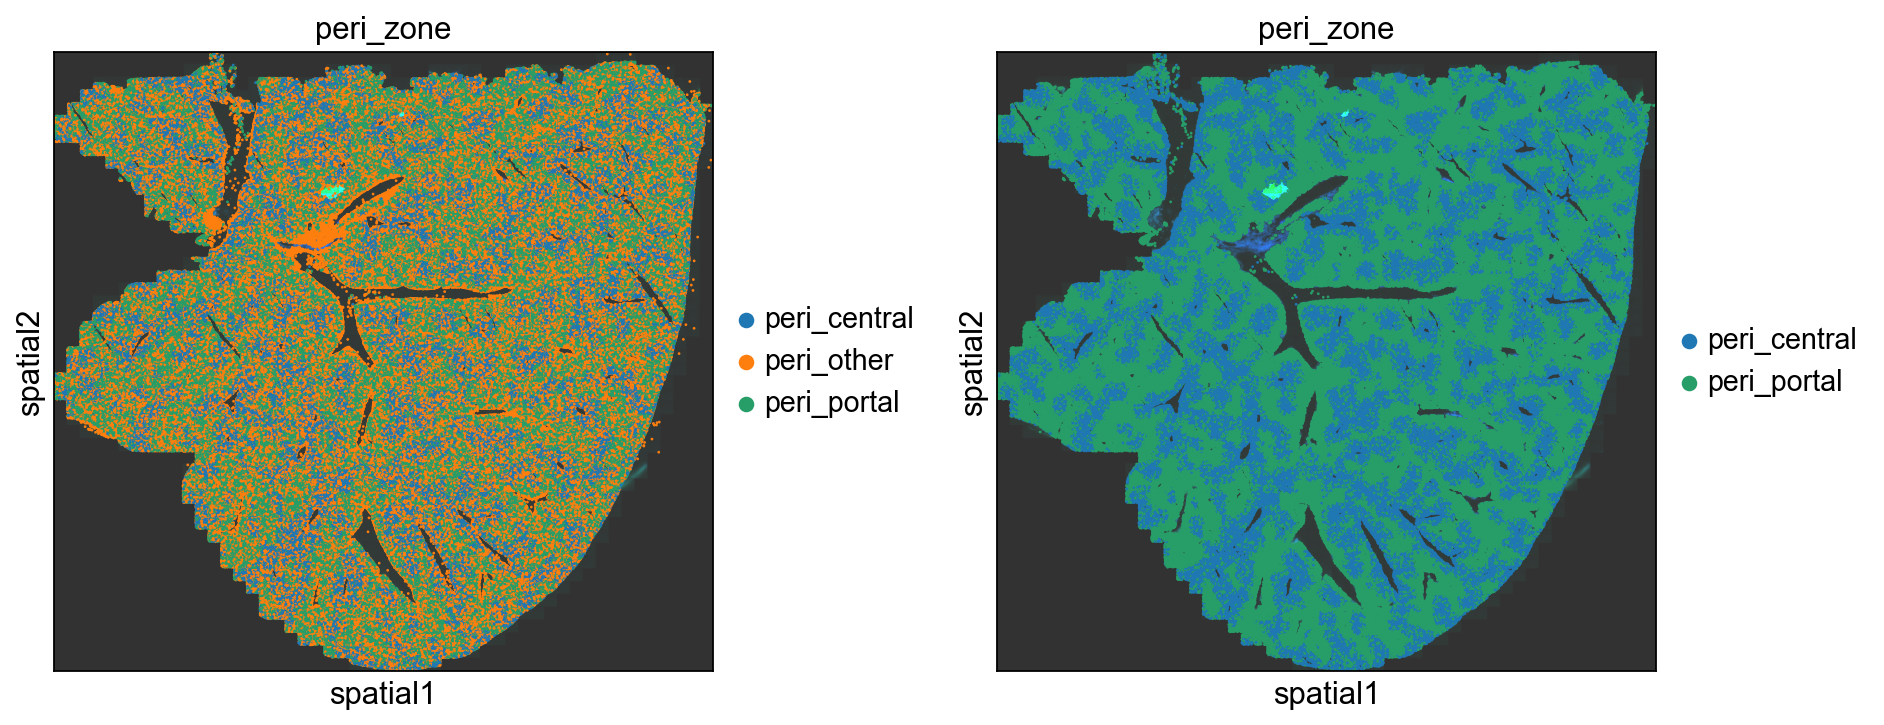

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sq.pl.spatial_scatter(adata, img="hires", size=5, color="peri_zone", library_id=library_id, ax=axes[0])
sq.pl.spatial_scatter(adata, img="hires", groups=['peri_central', 'peri_portal'], size=5, color="peri_zone", library_id=library_id, ax=axes[1])
plt.tight_layout()

### Finding marker genes
We will proceed to calculate a ranking for highly differential genes within each peri_zone group. Notably, we have omitted the "peri_other" group from this calculation, as it falls outside the scope of our current focus.

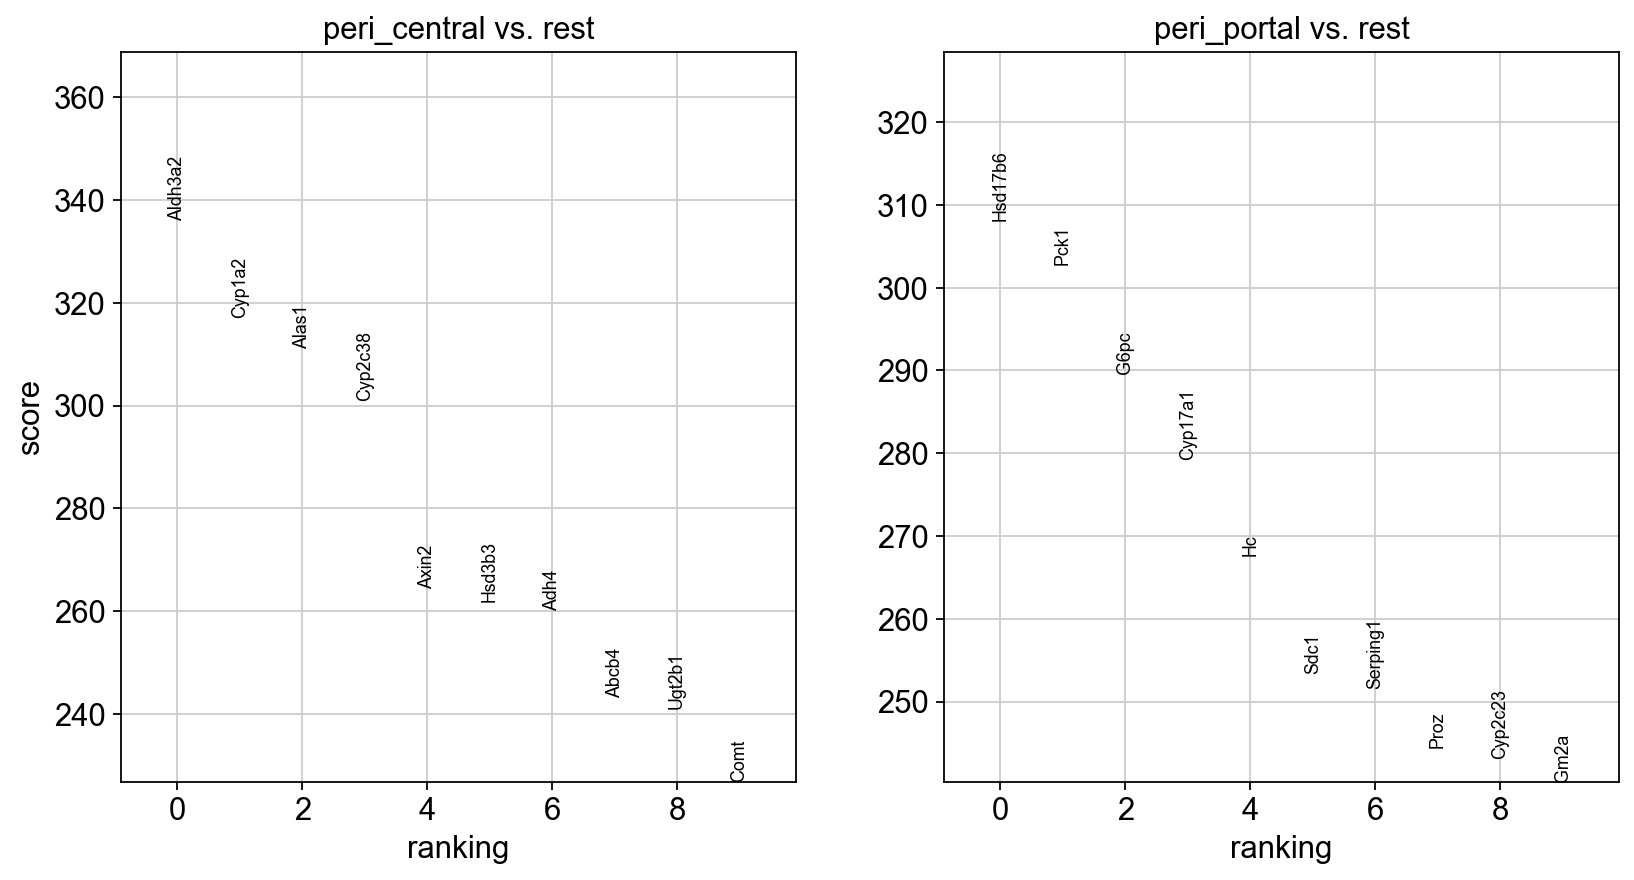

In [33]:
sc.tl.rank_genes_groups(adata, groupby="peri_zone", groups=['peri_central', 'peri_portal'], method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [34]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

peri_central peri_portal
0      Aldh3a2     Hsd17b6
1       Cyp1a2        Pck1
2        Alas1        G6pc
3      Cyp2c38     Cyp17a1
4        Axin2          Hc

Choose the top one marker from each group for spatial-scatter plottings.

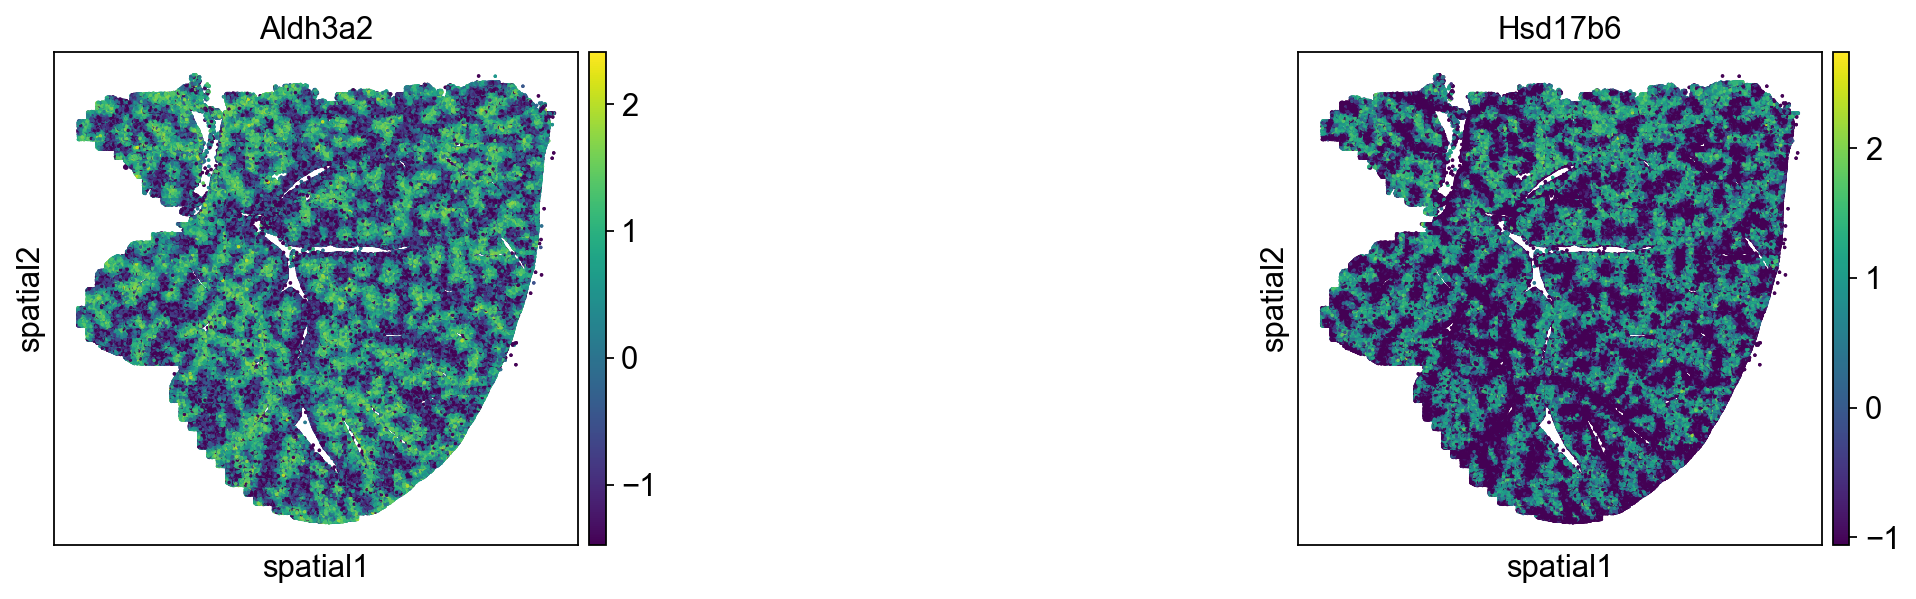

In [35]:
sq.pl.spatial_scatter(adata, shape=None, size=0.5, color=["Aldh3a2", "Hsd17b6"], library_id=library_id, figsize=(8, 4))

Furthermore, we have elected to incorporate the two genes, namely Vwf and Axin2, which were showcased in the squidpy tutorial, as our ultimate input variables for subsequent spatial-live visualization.

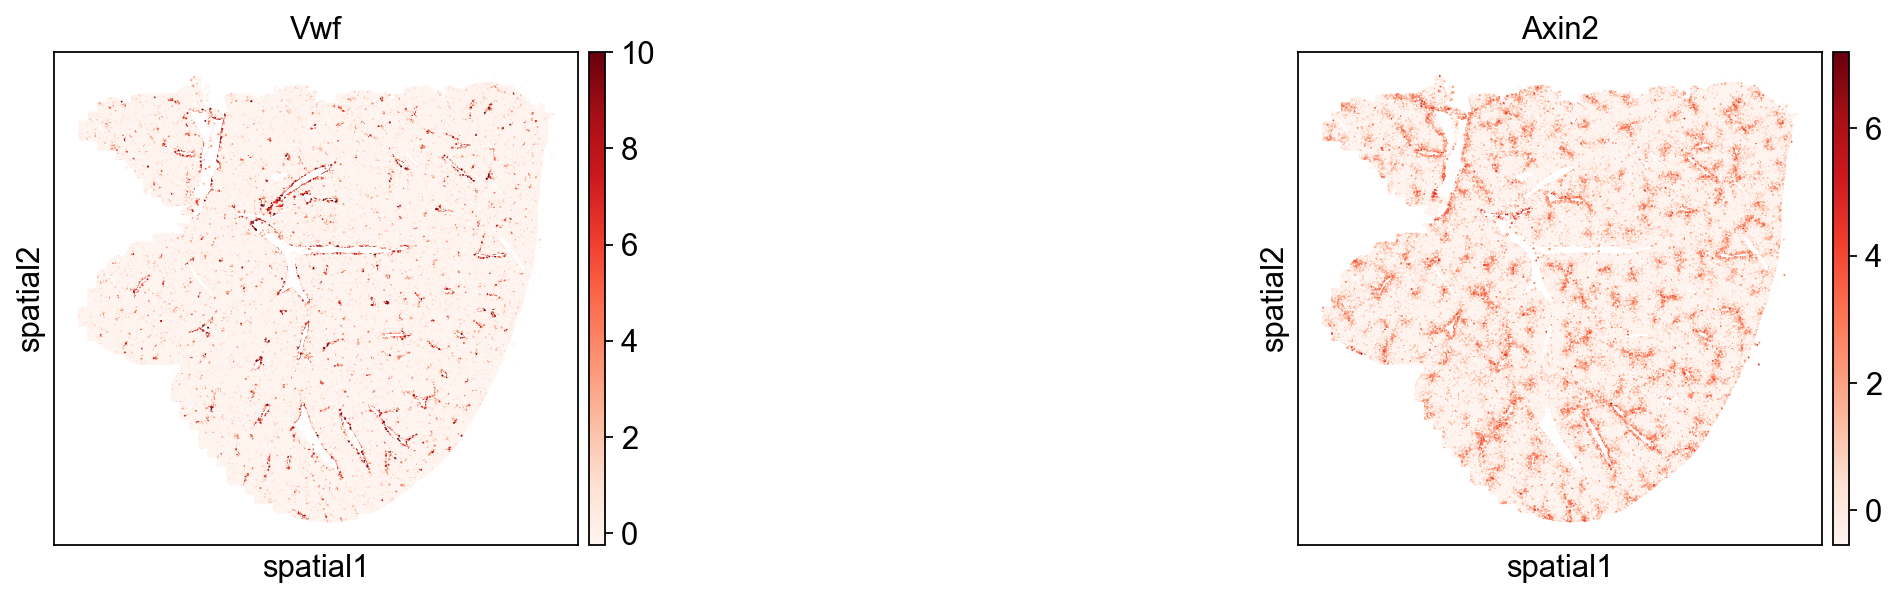

In [36]:
sq.pl.spatial_scatter(adata, img=False, size=5, color=["Vwf", "Axin2"], cmap="Reds", library_id=library_id, figsize=(8, 4))

## Preparing input files for spatial-live

Now we are ready to extract the necessary data columns for the spatial-live input CSV file. This entails a set of essential columns, notably "id:barcode", "pos:pixel_x", and "pos:pixel_y". Additionally, we aim to incorporate one categorical variable, namely "char:peri_zone", as well as two numerical variables, "num:Vwf" and "num:Axin2". Furthermore, we'll designate two additional genes for generating heatmap plots, "gene:Aldh3a2" and "gene:Hsd17b6" from the top markers in previous sections.


Firstly, we extract the relevant columns corresponding to designated genes from the adata object.

In [37]:
csv_out_df = sc.get.obs_df(adata, keys=['peri_zone', 'Vwf', 'Axin2', 'Aldh3a2', 'Hsd17b6'])
csv_out_df.head(3)

peri_zone    Vwf  Axin2  Aldh3a2  \
10482024599960584593741782560798328923   peri_central  0.904  0.422    1.071   
111551578131181081835796893618918348842    peri_other -0.247 -0.546   -0.450   
11173636076188568650971531877509781259    peri_portal -0.247 -0.546    0.912   

                                         Hsd17b6  
10482024599960584593741782560798328923    -1.061  
111551578131181081835796893618918348842   -0.443  
11173636076188568650971531877509781259    -1.061

Then, we extract the positions of each cell (spot) in pixel space coordinating with the employed image. As a result, we will persist in utilizing the down-scaled and adjusted "hires" image to compute the pixel positions of each cell. Additionally, it's essential to account for disparities in the origin points (left, up) between the image coordinate system and the spatial-live pixel coordinate system (left, bottom).

In [38]:
hires_maxY = adjusted.shape[0]

csv_out_df['pixel_x'] = adata.obsm['spatial'][:,0]
# translate the origin point (Y-axis) to be consistent with the spatial-lvv pixel coordinate
csv_out_df['pixel_y'] = hires_maxY - adata.obsm['spatial'][:,1]

csv_out_df.head(3)

peri_zone    Vwf  Axin2  Aldh3a2  \
10482024599960584593741782560798328923   peri_central  0.904  0.422    1.071   
111551578131181081835796893618918348842    peri_other -0.247 -0.546   -0.450   
11173636076188568650971531877509781259    peri_portal -0.247 -0.546    0.912   

                                         Hsd17b6   pixel_x  pixel_y  
10482024599960584593741782560798328923    -1.061  2746.355   68.591  
111551578131181081835796893618918348842   -0.443  2761.803   68.486  
11173636076188568650971531877509781259    -1.061  2709.060  111.925

And we further change the column names to comply with the rules from spatial-live, refer to the documents.

In [39]:
csv_out_df.rename(columns={
                    "peri_zone": "char:peri_zone", 
                    "Vwf": "num:Vwf",
                    "Axin2": "num:Axin2",
                    "Aldh3a2": "gene:Aldh3a2",
                    "Hsd17b6": "gene:Hsd17b6",
                    "pixel_x": "pos:pixel_x",
                    "pixel_y": "pos:pixel_y"
                  }, inplace=True)
csv_out_df.head(3)

char:peri_zone  num:Vwf  num:Axin2  \
10482024599960584593741782560798328923    peri_central    0.904      0.422   
111551578131181081835796893618918348842     peri_other   -0.247     -0.546   
11173636076188568650971531877509781259     peri_portal   -0.247     -0.546   

                                         gene:Aldh3a2  gene:Hsd17b6  \
10482024599960584593741782560798328923          1.071        -1.061   
111551578131181081835796893618918348842        -0.450        -0.443   
11173636076188568650971531877509781259          0.912        -1.061   

                                         pos:pixel_x  pos:pixel_y  
10482024599960584593741782560798328923      2746.355       68.591  
111551578131181081835796893618918348842     2761.803       68.486  
11173636076188568650971531877509781259      2709.060      111.925

To simplify matters, we will narrow down our final dataframe's scope to concentrate solely on hepatocyte cells, specifically the peri_central and peri_portal groups. However, we also intend to incorporate endothelial cells that exhibit the gene Vwf expression (with Vwf > 0).

In [40]:
# narrow down to hepatocyte cells
filter_idx = np.flatnonzero(csv_out_df['char:peri_zone'] != 'peri_other')

# We may also want to include endothelial cells with Vwf > 0 
vwf_idx = np.flatnonzero(csv_out_df['num:Vwf'] > 0)  

# merge them together and get the final filtered dataframe
union_idx = set(filter_idx).union(set(vwf_idx))
filter_out_df = csv_out_df.iloc[list(union_idx)]

In [41]:
filter_out_df.shape

(224756, 7)

In [42]:
filter_out_df.to_csv(datadir + "output/liver_demo.csv", index_label="id:spot", float_format='%.3f')

Noticed that we have both the liver_demo.csv file and the liver_demo.png image file available for spatial-live visualization now.

In [43]:
! tree ${WORKROOTDIR}/quickdemo/liver/

/Users/zhenqingye/projects/spatial-live/quickdemo/liver/
├── liver1slice1
│   ├── cell_by_gene.csv
│   ├── cell_metadata.csv
│   └── images
│       ├── manifest.json
│       ├── micron_to_mosaic_pixel_transform.csv
│       ├── mosaic_DAPI_z0.tif
│       └── mosaic_PolyT_z0.tif
└── output
    ├── liver_demo.csv
    └── liver_demo.png

3 directories, 8 files


In [44]:
! head ${WORKROOTDIR}/quickdemo/liver/output/liver_demo.csv

id:spot,char:peri_zone,num:Vwf,num:Axin2,gene:Aldh3a2,gene:Hsd17b6,pos:pixel_x,pos:pixel_y
10482024599960584593741782560798328923,peri_central,0.904,0.422,1.071,-1.061,2746.355,68.591
11173636076188568650971531877509781259,peri_portal,-0.247,-0.546,0.912,-1.061,2709.060,111.925
116320174062690702928590241926360429752,peri_central,-0.247,2.434,0.962,-1.061,2794.730,57.878
117618209435628285601583396363416663677,peri_portal,-0.247,2.058,1.041,0.015,2758.366,83.566
118681466178454285375254183862628606475,peri_other,9.402,-0.546,-1.476,-1.061,2794.231,102.131
119734422988290309520009455767728512386,peri_central,1.117,-0.546,1.114,-0.587,2704.038,81.650
127234768781846058678605511352431699402,peri_central,-0.247,2.722,1.476,-1.061,2790.465,73.567
131343870818306237824447462929184726576,peri_central,-0.247,-0.546,-0.636,-1.061,2713.909,83.113
134206186392275568276967134217212229277,peri_portal,-0.247,1.536,1.118,-1.061,2757.473,104.000


## A screen snapshot from spatial-live

Enclosed is a screen snapshot sourced from spatial-live, provided as a point of reference. This snapshot aptly demonstrates the tool's capacity to present a wealth of information through a single figure, featuring multiple layers in a visually compelling manner. In the image below, the light-blue and orange heatmaps correspond to the genes "Aldh3a2" and "Hsd17b6," respectively. Additionally, the green and purple column bars correspond to the genes "Vmf" and "Axin2," respectively.

PS: Given the substantial number of elements requiring rendering on the screen, notably each layer housing 228,036 data instances, the combined load of four layers nears 1 million elements. Consequently, it's possible to encounter slight sluggishness when employing spatial-live, particularly on low-end GPU cards, during the exploration of this liver demo.

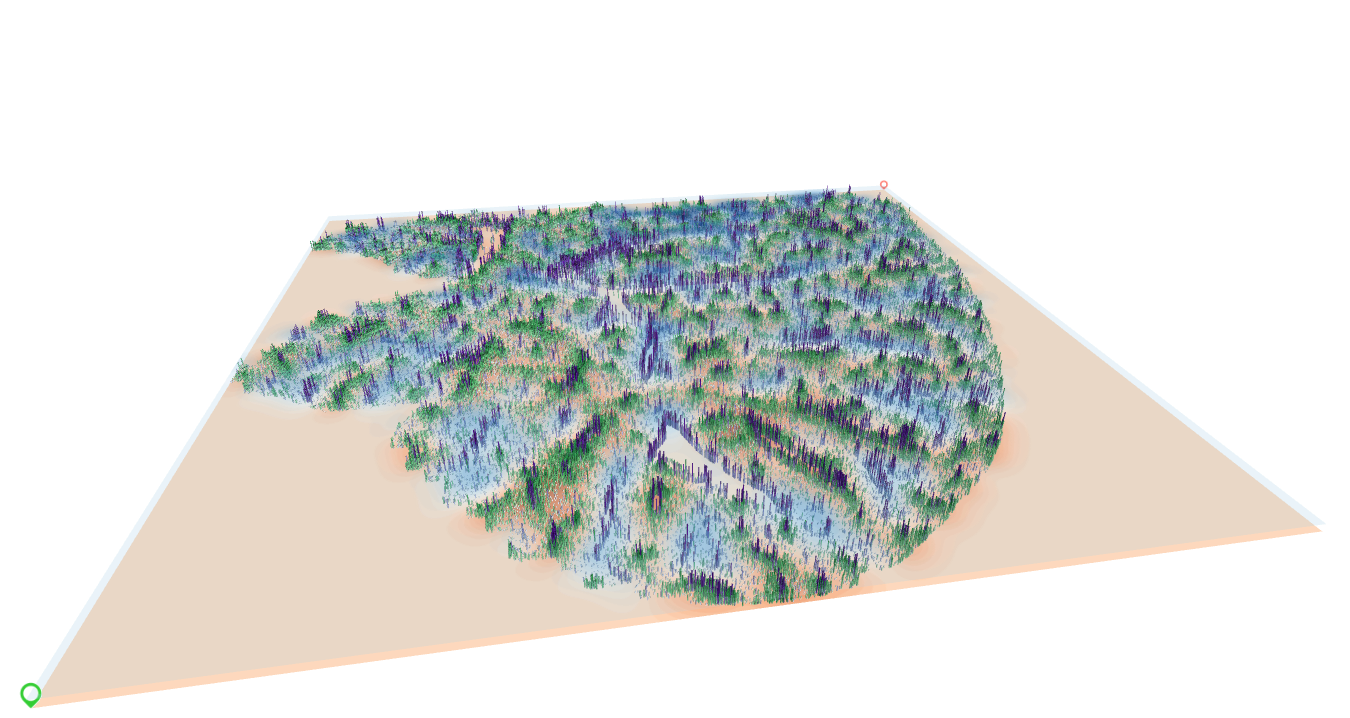

In [45]:
from IPython.display import Image as IPyImage
IPyImage("../images/spatial-live-liver.png")